<a href="https://colab.research.google.com/github/EjbejaranosAI/dl-medical-analysis-images/blob/main/NeurIPS_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NEURIPS 2022 CHALLENGE

  Author: Edison Bejarano

1. Transform image sets from multi formats to png format
2. Dataloader 
3. Architectures design
4. Training
5. Results




Some details of the challenge are here:
- https://pitch.com/public/afc6b0b0-5ffb-4472-955b-823aa17978aa
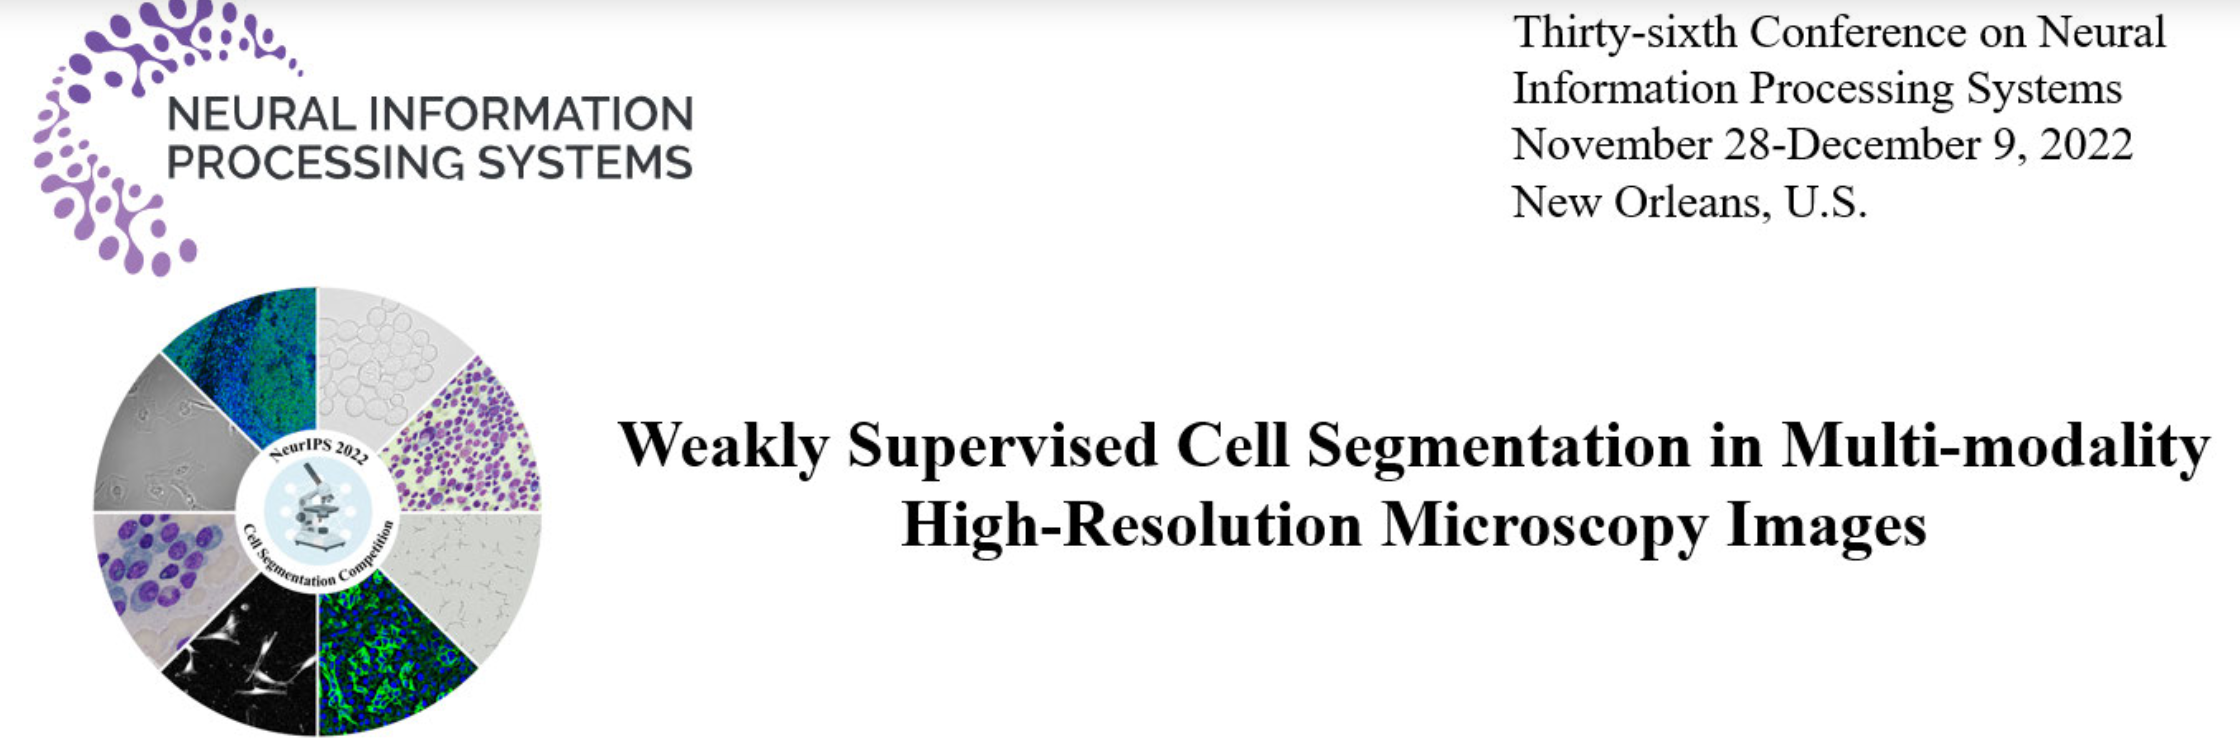


- Weakly supervised cell segmentation refers to the process of automatically identifying and separating individual cells in microscopy images using only partial or noisy annotations. This can be challenging because cells can have complex shapes and vary significantly in appearance, especially in multi-modality images that contain multiple types of information about the cells.

- There are several approaches that can be used for weakly supervised cell segmentation in multi-modality microscopy images. One approach is to use machine learning techniques such as convolutional neural networks (CNNs) to learn to segment cells from the annotated data. These CNNs can be trained to recognize the characteristic features of cells in the images and use this information to segment the cells.

## 1. Transform image sets from multi formats to png format

Copy the link that contain the data

In [ ]:
#!cp https://drive.google.com/drive/folders/1NmDiOuLn58ZT2MMO1z9Aj_IYcVzrWqim?usp=share_link .

Copy the preproces script and executed (take care that the direcotory name, contain the same name that the have in the pre_process_3class.py)

In [1]:
#!python3 pre_process_3class.py
# Python Package Index (PyPI)
!pip install -q torchmetrics

     |████████████████████████████████| 512 kB 6.3 MB/s 


Read original data and convert from tiff and tif format to png using pre_process_3class.py, that also, prepare the images to have 3 classes in the image segmentation.
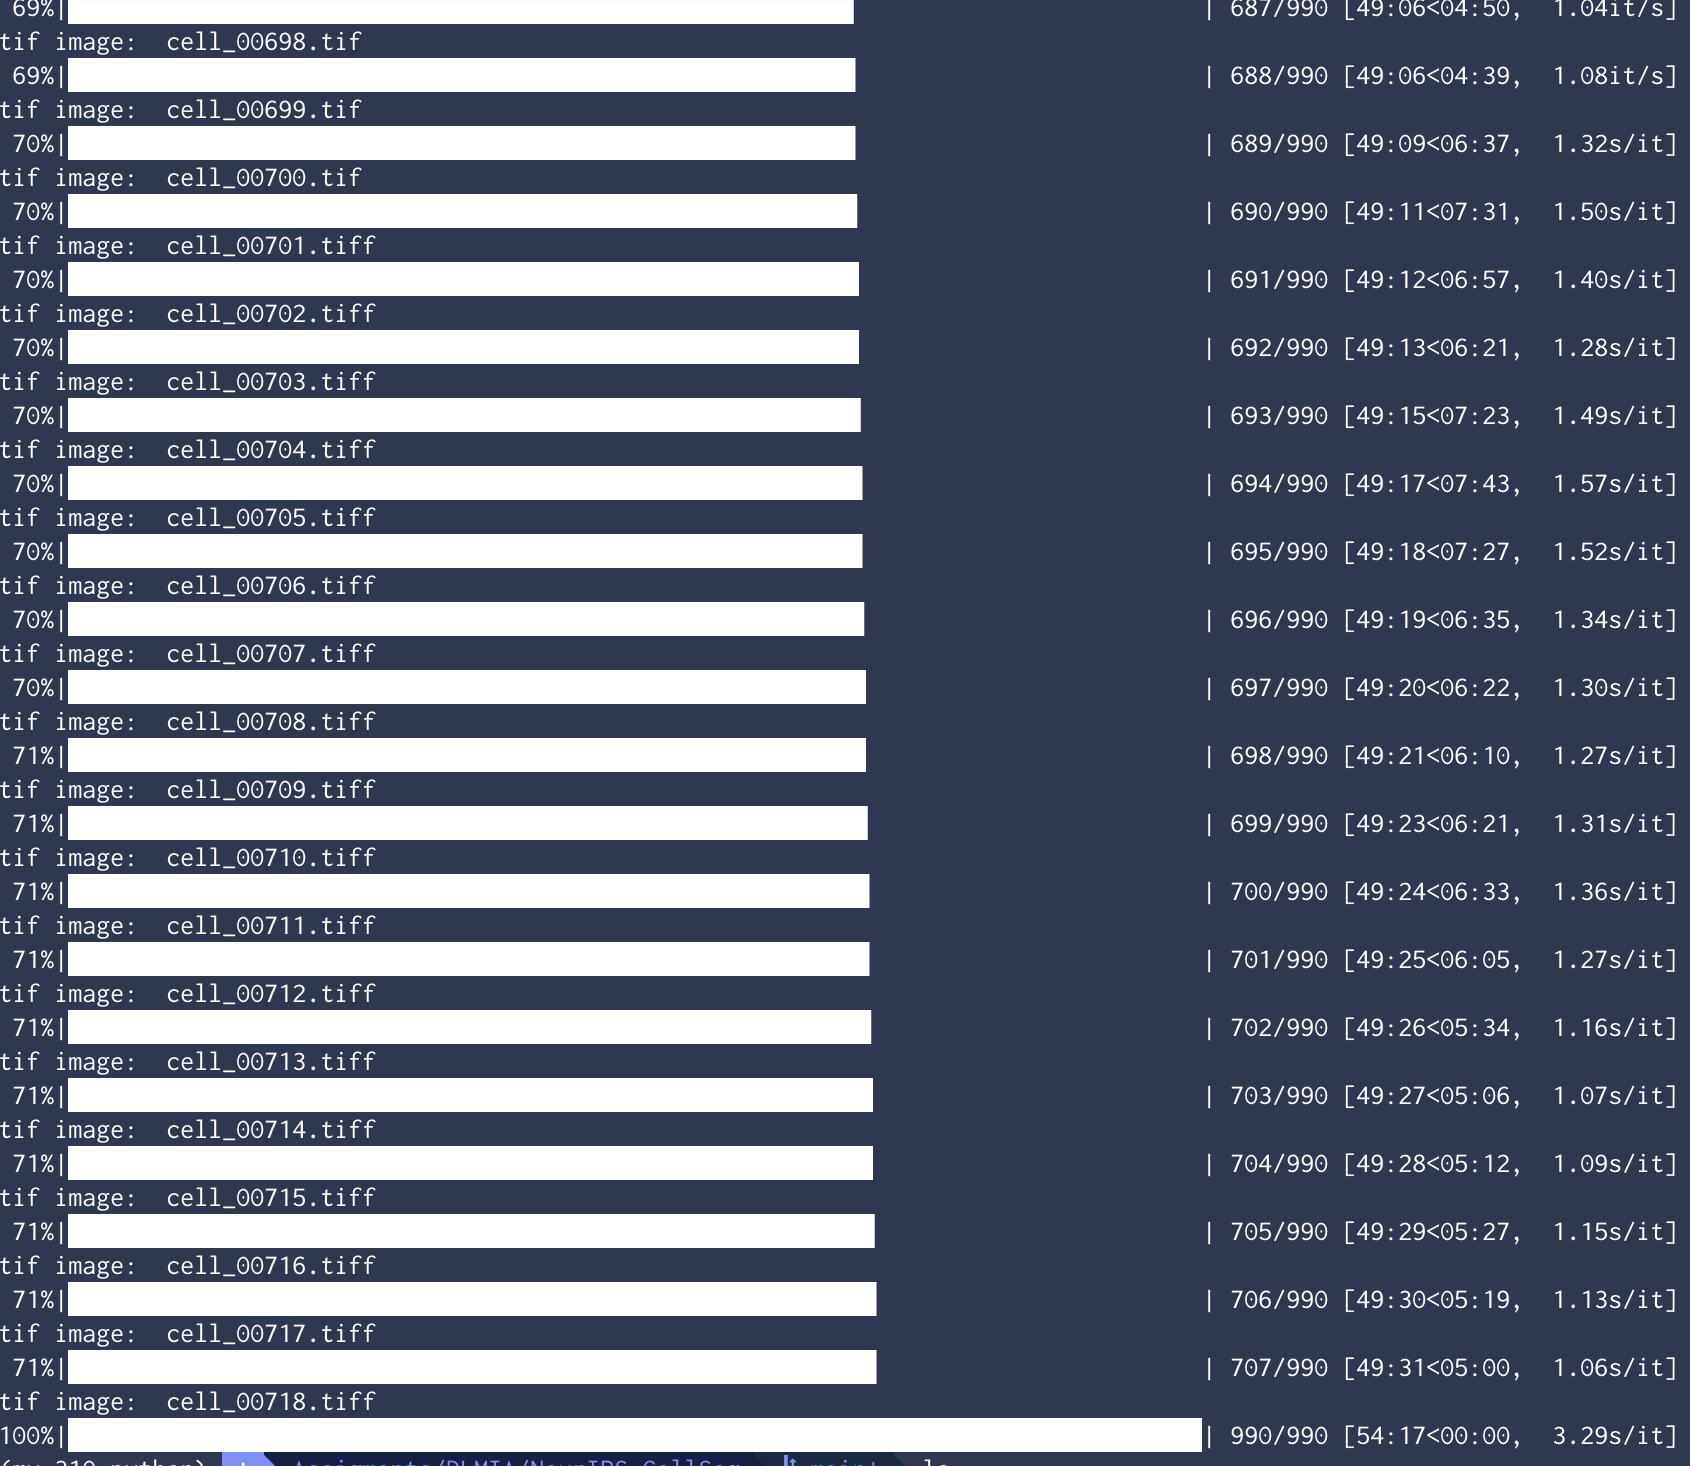




- As it was observed in the transformation of the format in the images, some of then, it was containing corrupted images, with that it was tried to change the way of the transofrmation and, also, read with other libraries, but did not present good results, that is why it was located and them delete it from the original image set.

Finally the data output it is going to foun ot in the following link: 
- https://drive.google.com/drive/folders/1p2zfxXY45PH4gNOFbrD00s9pHKFmgSh_?usp=share_link


## 2. Dataloader

* Import libraries
* Obtaining data
* Helper functions
* Read data and plot examples
* Create a dataloader

### Importing libraries

In [8]:
#!pip install -U segmentation-models-pytorch albumentations --user 

In [25]:
# Importing libraries
import os
import cv2
import sys
import glob
import torch 
import imageio
import tensorflow
import torch as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
from keras import backend as K
from skimage.transform import resize
from skimage.io import imread, imshow

from tensorflow.keras import layers
from pickleshare import print_function
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [3]:
# Checking the gpu available
!nvidia-smi

Sat Dec 31 10:45:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Obtaining data

In [ ]:
#!cp -r /content/drive/MyDrive/Colab_Notebooks/DLMIA/pre_process_3class.py .
#!cp -r /content/drive/MyDrive/Colab_Notebooks/DLMIA/data/train .

In [4]:
# Uncomment to bring the data from the Drive directory 
!cp -r /content/drive/MyDrive/Colab_Notebooks/DLMIA/data/Train_Pre_3class .

Checking the number of images for images and labels 

In [5]:
print("The number of images obtained are: ",len(os.listdir("/content/Train_Pre_3class/images")))
print("The number of labels obtained are: ",len(os.listdir("/content/Train_Pre_3class/labels")))

The number of images obtained are:  990
The number of labels obtained are:  990


### Helpr functions

In [37]:
def get_paths(root_data):
  train_dir = os.listdir(root_data)
  path_image = os.path.join(root_data,train_dir[0])
  path_label = os.path.join(root_data,train_dir[1])

  return path_image, path_label

def get_path_images(root_path):
  path_image, path_label= get_paths(root_path)
  #print(path_image)
  #print(path_label)
  img_full_path = []
  label_full_path = []

  list_img = os.listdir(path_image)
  list_label = os.listdir(path_label)
  #print(list_img[0])
  #print(list_label[0])
  [img_full_path.append(os.path.join(path_image,path_img)) for path_img in list_img]
  #print(img_full_path[0])
  [label_full_path.append(os.path.join(path_label,path_lb)) for path_lb in list_label]
  #print(label_full_path[0])
  print(f"It was founded {len(img_full_path)} paths for images")
  print(f"It was founded {len(label_full_path)} paths for labels")

  return img_full_path, label_full_path



def plot_img_from_path(list_path_1,list_path_2, num_iter):

  img_path_1 = list_path_1[num_iter:num_iter+5]
  img_path_2 = list_path_2[num_iter:num_iter+5]

  # Load the images and store them in a list
  images1 = [plt.imread(path) for path in img_path_1]
  images2 = [plt.imread(path) for path in img_path_2]

  # Create a figure with 10 subplots
  fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 10))
  for ax, image in zip(axs.flat, images1):
      ax.imshow(image)
      ax.set_title(image.shape)
  plt.show()

  fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 10))
  for ax, image in zip(axs.flat, images2):
      ax.imshow(image, cmap='gray')
      ax.set_title(image.shape)
  plt.show()



### Read data and plot examples

In [7]:
root_train = "/content/Train_Pre_3class"
img_path,label_path = get_path_images(root_train)

It was founded 990 paths for images
It was founded 990 paths for labels


In [8]:
import os

input_dir = "/content/Train_Pre_3class/images"
target_dir = "/content/Train_Pre_3class/labels"
img_size = (256, 256)
num_classes = 3
batch_size = 16

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".bmp") or fname.endswith(".png") or fname.endswith(".tif") or fname.endswith(".tiff")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "||", target_path)

Number of samples: 990
/content/Train_Pre_3class/images/cell_00001.png || /content/Train_Pre_3class/labels/cell_00001_label.png
/content/Train_Pre_3class/images/cell_00002.png || /content/Train_Pre_3class/labels/cell_00002_label.png
/content/Train_Pre_3class/images/cell_00003.png || /content/Train_Pre_3class/labels/cell_00003_label.png
/content/Train_Pre_3class/images/cell_00004.png || /content/Train_Pre_3class/labels/cell_00004_label.png
/content/Train_Pre_3class/images/cell_00005.png || /content/Train_Pre_3class/labels/cell_00005_label.png
/content/Train_Pre_3class/images/cell_00006.png || /content/Train_Pre_3class/labels/cell_00006_label.png
/content/Train_Pre_3class/images/cell_00007.png || /content/Train_Pre_3class/labels/cell_00007_label.png
/content/Train_Pre_3class/images/cell_00008.png || /content/Train_Pre_3class/labels/cell_00008_label.png
/content/Train_Pre_3class/images/cell_00009.png || /content/Train_Pre_3class/labels/cell_00009_label.png
/content/Train_Pre_3class/images

### Plot images

Here it was made a plot through the dataset, with the intention of explore the size and characteristics of the images

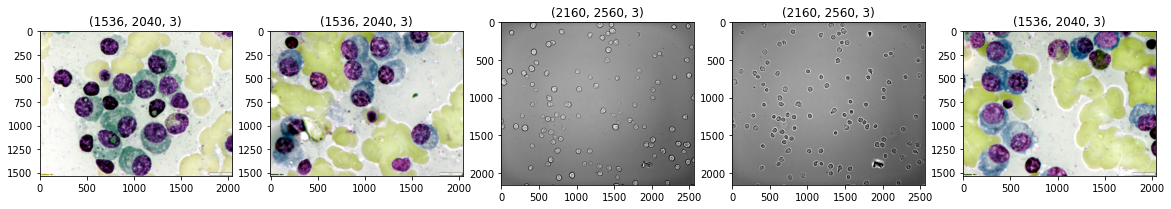

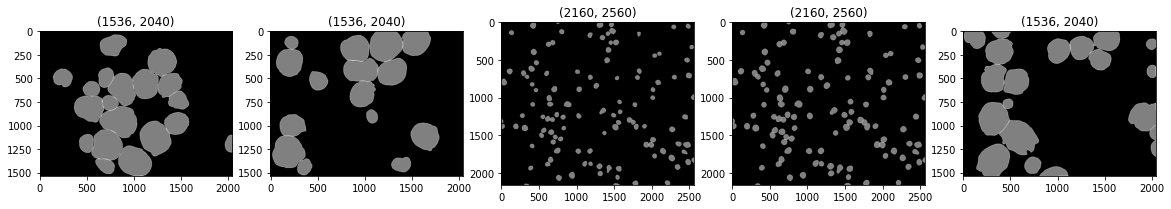

In [43]:
plot_img_from_path(input_img_paths,target_img_paths,10)

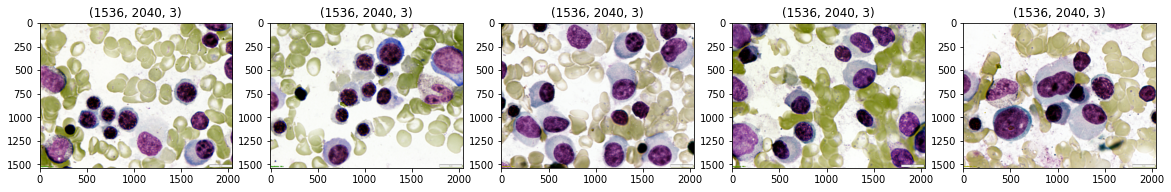

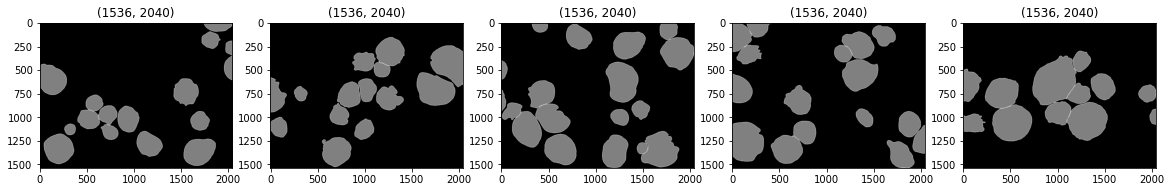

In [38]:
plot_img_from_path(input_img_paths,target_img_paths,100)

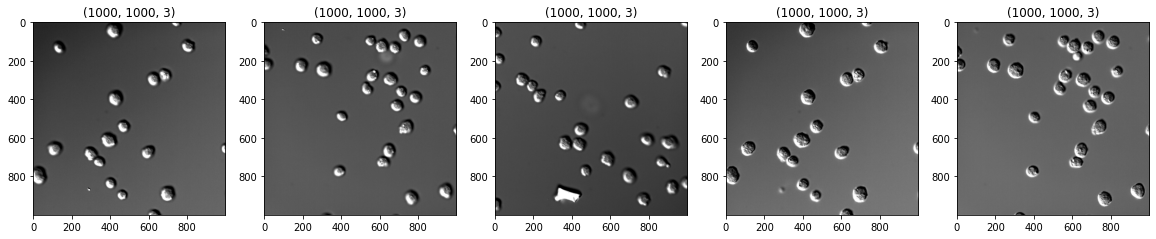

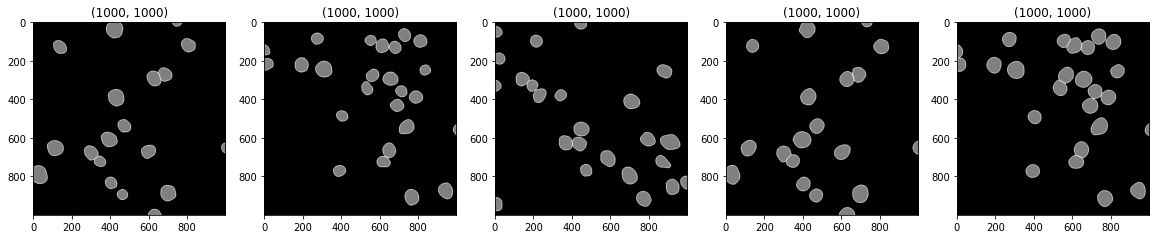

In [39]:
plot_img_from_path(input_img_paths,target_img_paths,300)

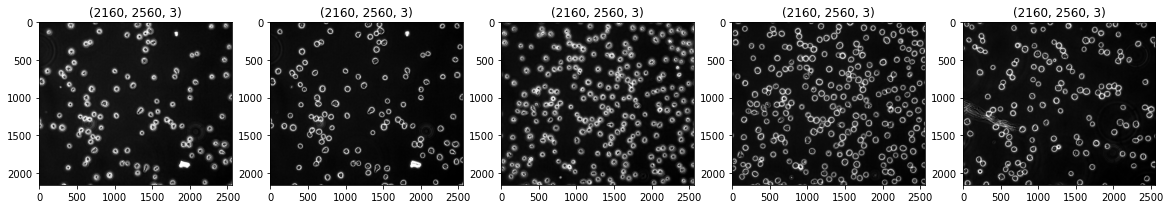

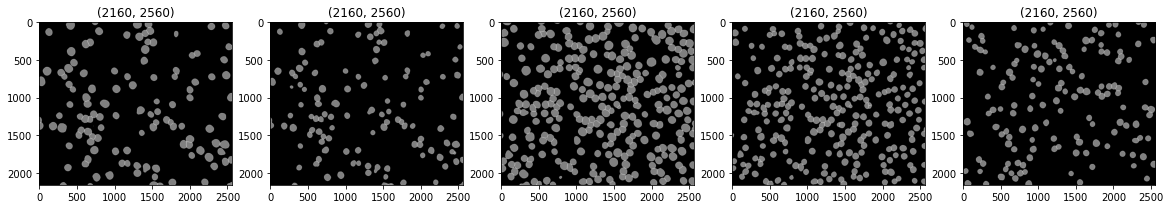

In [40]:
plot_img_from_path(input_img_paths,target_img_paths,500)

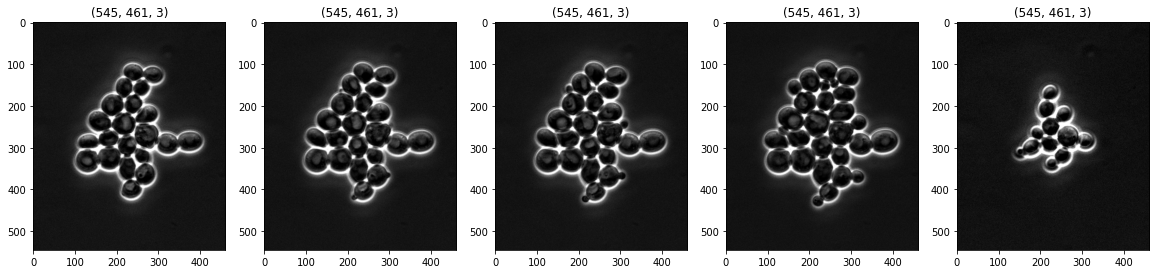

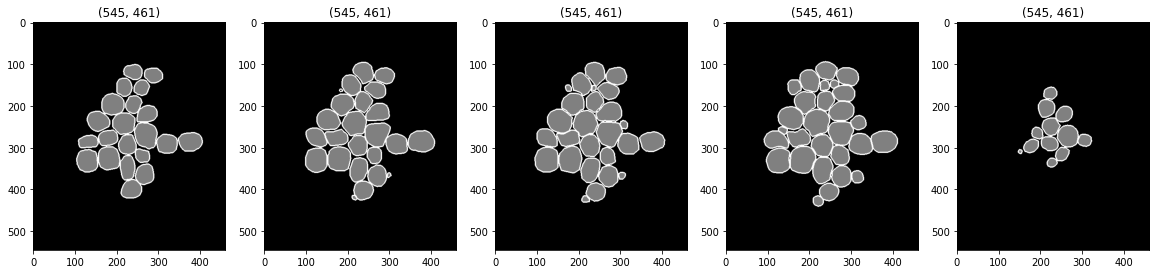

In [41]:
plot_img_from_path(input_img_paths,target_img_paths,600)

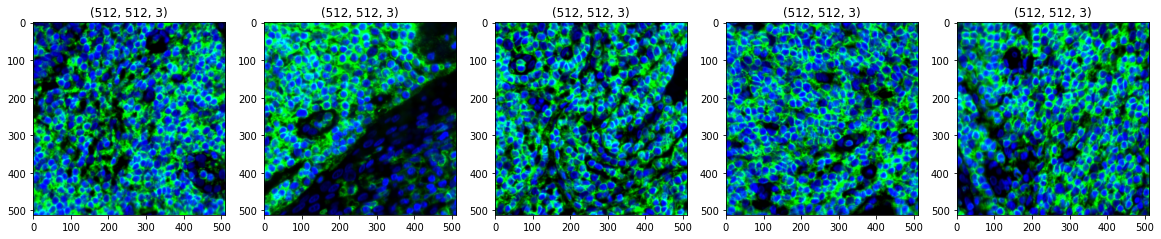

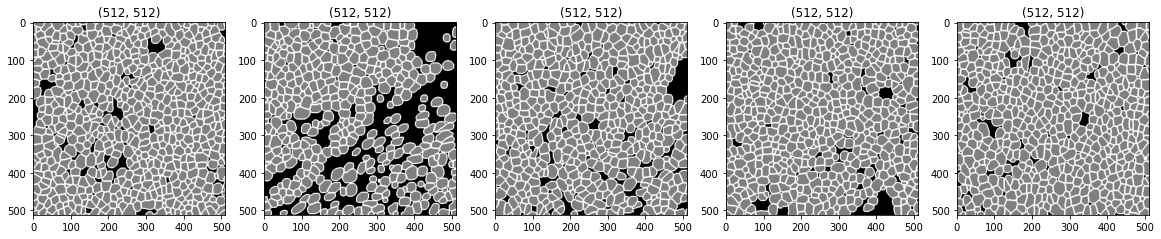

In [42]:
plot_img_from_path(input_img_paths,target_img_paths,800)

As it is observed, trhought the dataset it was 

### Dataloader created for pythorch pipeline

In [13]:

class CellSegmentationDataset(Dataset):
    def __init__(self, image_filenames, label_filenames, transform=None):
        self.image_filenames = image_filenames
        self.label_filenames = label_filenames
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        # Load image and label
        image = cv2.imread(self.image_filenames[idx])
        label = cv2.imread(self.label_filenames[idx])
        # Apply transforms (if any)
        if self.transform:
            image = self.transform(image)
            label = self.transform(label)
        return image, label

# Define resize transform
#resize_transform = transforms.Compose([
#    transforms.ToPILImage(),
#    transforms.Resize(img_size),
#    transforms.ToTensor()
#])



#def normalize(image):
#    return (image - image.mean()) / image.std()

#def collate_fn(batch):
#    images, labels = zip(*batch)
#    return torch.stack(images), torch.stack(labels)





resize_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(img_size),
    transforms.Grayscale(num_output_channels=3),  # Add this line to convert to grayscale
    transforms.ToTensor()
])

In [14]:
from sklearn.model_selection import train_test_split

# Create list of image and label filenames
image_filenames = input_img_paths
label_filenames = target_img_paths


# Split the image and label filenames into training and validation sets
image_train, image_valid, label_train, label_valid = train_test_split(image_filenames, label_filenames, test_size=0.2)
print(f"The number of images to train are: {len(image_train)}")
print(f"The number of labels to train are: {len(label_train)}")
print(f"The number of images to validate are: {len(image_valid)}")
print(f"The number of labels to validate are: {len(label_valid)}")

# Create the training dataset and dataloader
dataset_train = CellSegmentationDataset(image_train, label_train, transform=resize_transform)
dataloader_train = DataLoader(dataset_train, batch_size=16, shuffle=True,num_workers=2)
# Create the validation dataset and dataloader
dataset_valid = CellSegmentationDataset(image_valid, label_valid, transform=resize_transform)
dataloader_valid = DataLoader(dataset_valid, batch_size=16, shuffle=False,num_workers=2)

# Create dataset and data loader
#dataset = CellSegmentationDataset(image_filenames, label_filenames, transform=resize_transform)
#dataloader = DataLoader(dataset, batch_size=16,collate_fn=collate_fn, shuffle=True, num_workers=4)
#dataloader = DataLoader(dataset, shuffle=True, num_workers=2)

The number of images to train are: 792
The number of labels to train are: 792
The number of images to validate are: 198
The number of labels to validate are: 198


##### Checking dataloader iterator for batch and images

In [ ]:
for i, (images, labels) in enumerate(dataloader_train):
    print(f"Batch {i}, min: {images.min():.2f}, max: {images.max():.2f}")

Batch 0, min: 0.00, max: 1.00
Batch 1, min: 0.00, max: 1.00
Batch 2, min: 0.00, max: 1.00
Batch 3, min: 0.00, max: 1.00
Batch 4, min: 0.00, max: 1.00
Batch 5, min: 0.00, max: 1.00
Batch 6, min: 0.00, max: 1.00
Batch 7, min: 0.00, max: 1.00
Batch 8, min: 0.00, max: 1.00
Batch 9, min: 0.00, max: 1.00
Batch 10, min: 0.00, max: 1.00
Batch 11, min: 0.00, max: 1.00
Batch 12, min: 0.00, max: 1.00
Batch 13, min: 0.00, max: 1.00
Batch 14, min: 0.00, max: 1.00
Batch 15, min: 0.00, max: 1.00
Batch 16, min: 0.00, max: 1.00
Batch 17, min: 0.00, max: 1.00
Batch 18, min: 0.00, max: 1.00
Batch 19, min: 0.00, max: 1.00
Batch 20, min: 0.00, max: 1.00
Batch 21, min: 0.00, max: 1.00
Batch 22, min: 0.00, max: 1.00
Batch 23, min: 0.00, max: 1.00
Batch 24, min: 0.00, max: 1.00
Batch 25, min: 0.00, max: 1.00
Batch 26, min: 0.00, max: 1.00
Batch 27, min: 0.00, max: 1.00
Batch 28, min: 0.00, max: 1.00
Batch 29, min: 0.00, max: 1.00
Batch 30, min: 0.00, max: 1.00
Batch 31, min: 0.00, max: 1.00
Batch 32, min: 0.0

In [ ]:
# Iterate over the DataLoader and print the size of each batch
for i, (images, labels) in enumerate(dataloader):
    print(f"Batch {i}, images: {images.size()}, labels: {labels.size()}")

Batch 0, images: torch.Size([1, 1, 256, 256]), labels: torch.Size([1, 1, 256, 256])
Batch 1, images: torch.Size([1, 1, 256, 256]), labels: torch.Size([1, 1, 256, 256])
Batch 2, images: torch.Size([1, 1, 256, 256]), labels: torch.Size([1, 1, 256, 256])
Batch 3, images: torch.Size([1, 1, 256, 256]), labels: torch.Size([1, 1, 256, 256])
Batch 4, images: torch.Size([1, 1, 256, 256]), labels: torch.Size([1, 1, 256, 256])
Batch 5, images: torch.Size([1, 1, 256, 256]), labels: torch.Size([1, 1, 256, 256])
Batch 6, images: torch.Size([1, 1, 256, 256]), labels: torch.Size([1, 1, 256, 256])
Batch 7, images: torch.Size([1, 1, 256, 256]), labels: torch.Size([1, 1, 256, 256])
Batch 8, images: torch.Size([1, 1, 256, 256]), labels: torch.Size([1, 1, 256, 256])
Batch 9, images: torch.Size([1, 1, 256, 256]), labels: torch.Size([1, 1, 256, 256])
Batch 10, images: torch.Size([1, 1, 256, 256]), labels: torch.Size([1, 1, 256, 256])
Batch 11, images: torch.Size([1, 1, 256, 256]), labels: torch.Size([1, 1, 2

#### Check the tensor size for all the imaages

In [11]:
import matplotlib.pyplot as plt
# Iterate through data samples
for i, (images, labels) in enumerate(dataloader):
    # Print size of each image and label
    for j, (image, label) in enumerate(zip(images, labels)):
        print(f'Image {i*dataloader.batch_size+j+1}: {image.size()}, Label {i*dataloader.batch_size+j+1}: {label.size()}')
    pass

NameError: ignored

#### Checking the size for the labels and images

In [ ]:
# Import matplotlib
import matplotlib.pyplot as plt

# Iterate through data samples
for i, (images, labels) in enumerate(dataloader):
    # Print size of each image and label
    for j, (image, label) in enumerate(zip(images, labels)):
        print(f'Image {i*dataloader.batch_size+j+1}: {image.size()}, Label {i*dataloader.batch_size+j+1}: {label.size()}')
        
        # Select single channel of image
        image = image[0]  # Select first channel
        label = label[0]
        # Plot image and label
        plt.imshow(image, cmap='gray')  # Use grayscale color map
        plt.title(f'Image {i*dataloader.batch_size+j+1}')
        plt.show()
        plt.imshow(label, cmap='gray')  # Use grayscale color map
        plt.title(f'Label{i*dataloader.batch_size+j+1}')
        plt.show()


    # Do something with the data samples
    pass

# Segmentation architecture

##### First architecture

In [2]:
import torch.nn as nn

class UNET(nn.Module):
    
    def __init__(self, in_channels=3, classes=3):
        super(UNET, self).__init__()
        self.layers = [in_channels, 64, 128, 256, 512, 1024]
        
        self.double_conv_downs = nn.ModuleList(
            [self.__double_conv(layer, layer_n) for layer, layer_n in zip(self.layers[:-1], self.layers[1:])])
        
        self.up_trans = nn.ModuleList(
            [nn.ConvTranspose2d(layer, layer_n, kernel_size=2, stride=2)
             for layer, layer_n in zip(self.layers[::-1][:-2], self.layers[::-1][1:-1])])
            
        self.double_conv_ups = nn.ModuleList(
        [self.__double_conv(layer, layer//2) for layer in self.layers[::-1][:-2]])
        
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.final_conv = nn.Conv2d(64, classes, kernel_size=1)

        
    def __double_conv(self, in_channels, out_channels):
        conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        return conv
    
    def forward(self, x):
        # down layers
        concat_layers = []
        
        for down in self.double_conv_downs:
            x = down(x)
            if down != self.double_conv_downs[-1]:
                concat_layers.append(x)
                x = self.max_pool_2x2(x)
        
        concat_layers = concat_layers[::-1]
        
        # up layers
        for up_trans, double_conv_up, concat_layer  in zip(self.up_trans, self.double_conv_ups, concat_layers):
            x = up_trans(x)
            if x.shape != concat_layer.shape:
                x = TF.resize(x, concat_layer.shape[2:])
            
            concatenated = torch.cat((concat_layer, x), dim=1)
            x = double_conv_up(concatenated)
            
        x = self.final_conv(x)
        
        return x 

In [ ]:
import torch
import torch.nn as nn
from tqdm import tqdm

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        # Create encoder layers
        self.encoder1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.encoder2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.encoder3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.encoder4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        
        # Create decoder layers
        self.decoder1 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.decoder2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.decoder3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.decoder4 = nn.Conv2d(64, out_channels, kernel_size=3, padding=1)
        
    def forward(self, x):
        # Encoder
        x1 = self.encoder1(x)
        x2 = self.encoder2(x1)
        x3 = self.encoder3(x2)
        x4 = self.encoder4(x3)
        # Decoder
        x5 = self.decoder1(x4)
        x6 = self.decoder2(x5)
        x7 = self.decoder3(x6)
        x8 = self.decoder4(x7)
        return x8

In [ ]:
import torchmetrics
from torchmetrics import F1Score
from  torchmetrics.classification import MulticlassF1Score

def train(model, train_loader, valid_loader, criterion, optimizer, device):
    # Set the model to training mode
    model.train()
    train_loss = 0.0
    #if f1_score_fn == MulticlassF1Score:
    #    train_f1_score = f1_score_fn(num_classes=3)
    #else:
    #    train_f1_score = f1_score_fn()
    #train_f1_score = f1_score_fn(num_classes=3)
    #train_f1_score = F1Score(task='multiclass',num_classes=3)
    #train_f1_score = train_f1_score.to(device)
    train_f1_score = F1Score(task='multiclass',num_classes=3).to(device)

    # Loop through the training data
    for data, target in tqdm(train_loader):
        # Move the data and target to the specified device
        data, target = data.to(device), target.to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculate the loss
        loss = criterion(output, target)
        # Backward pass
        loss.backward()
        # Update the weights
        optimizer.step()
        # Accumulate the loss and F1 score
        train_loss += loss.item()
        train_f1_score(output, target)

    # Calculate the average training loss and F1 score
    train_loss /= len(train_loader)

    train_f1_score /= len(train_loader)

    # Evaluate the model on the validation set
    valid_loss, valid_f1_score = evaluate(model, valid_loader, criterion, device)

    return train_loss, train_f1_score, valid_loss, valid_f1_score


In [ ]:
def evaluate(model, valid_loader, criterion, device):
    # Set the model to evaluation mode
    model.eval()
    valid_loss = 0.0
    #if f1_score_fn == MulticlassF1Score:
    #  valid_f1_score = MulticlassF1Score(num_classes=3)
    #else:
    #  valid_f1_score = F1Score()
    #valid_f1_score = MulticlassF1Score(num_classes=3)
    valid_f1_score = F1Score(task='multiclass',num_classes=3)
    valid_f1_score = valid_f1_score.to(device)

    # Loop through the validation data
    with torch.no_grad():
        for data, target in tqdm(valid_loader):
            # Move the data and target to the specified device
            data, target = data.to(device), target.to(device)
            # Forward pass
            output = model(data)
            # Calculate the loss
            loss = criterion(output, target)
            # Accumulate the loss and F1 score
            valid_loss += loss.item()

            valid_f1_score(output, target)

    # Calculate the average validation loss and F1 score
    valid_loss /= len(valid_loader)
    valid_f1_score /= len(valid_loader)

    return valid_loss, valid_f1_score


In [ ]:
LEARNING_RATE = 0.001
n_epochs = 5

# Create an instance of the UNET model with 3 input channels and 3 output classes
#model = UNet(in_channels=3, out_channels=3)
model = UNET(in_channels=3, classes=3)

# Define the optimizer

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
#optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)


# Set the device to "cuda" if a GPU is available, otherwise use the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("mps")
print(device)

# Move the model to the device
model = model.to(device)


# Set the number of epochs to train for

# Create lists to store the training and validation losses and F1 scores at each epoch
train_losses = []
train_f1_scores = []
valid_losses = []
valid_f1_scores = []

f1_score_fn = MulticlassF1Score
#f1_score_fn = torchmetrics.F1Score()

# Train the model for the specified number of epochs
for epoch in range(n_epochs):
  # Train the model for one epoch
  train_loss, train_f1_score, valid_loss, valid_f1_score = train(model, dataloader_train, dataloader_valid, criterion, optimizer, device)



  #train_loss, train_f1_score, valid_loss, valid_f1_score = train(model, dataloader_train, dataloader_valid, criterion, optimizer, device, f1_score_fn)
    
  # Store the losses and F1 scores
  train_losses.append(train_loss)
  train_f1_scores.append(train_f1_score)
  valid_losses.append(valid_loss)
  valid_f1_scores.append(valid_f1_score)
    
  # Print the results for the epoch
  print(f'Epoch {epoch+1}: train_loss={train_loss:.4f}, train_f1_score={train_f1_score.compute():.4f}, valid_loss={valid_loss:.4f}, valid_f1_score={valid_f1_score.compute():.4f}')

cuda


100%|██████████| 13/13 [00:11<00:00,  1.11it/s]


Epoch 1: train_loss=0.0071, train_f1_score=0.0000, valid_loss=0.0044, valid_f1_score=0.0000


100%|██████████| 13/13 [00:11<00:00,  1.11it/s]


Epoch 2: train_loss=0.0048, train_f1_score=0.0000, valid_loss=0.0043, valid_f1_score=0.0000


100%|██████████| 13/13 [00:11<00:00,  1.12it/s]


Epoch 3: train_loss=0.0048, train_f1_score=0.0000, valid_loss=0.0043, valid_f1_score=0.0000


100%|██████████| 13/13 [00:11<00:00,  1.12it/s]


Epoch 4: train_loss=0.0048, train_f1_score=0.0000, valid_loss=0.0043, valid_f1_score=0.0000


100%|██████████| 13/13 [00:11<00:00,  1.12it/s]

Epoch 5: train_loss=0.0048, train_f1_score=0.0000, valid_loss=0.0043, valid_f1_score=0.0000


In [ ]:
import torch
import torchmetrics

# Create some dummy prediction and target data
preds = torch.tensor([[0.9, 0.1, 0.0], [0.8, 0.1, 0.1], [0.3, 0.3, 0.4]])
targets = torch.tensor([2, 0, 1])

# Create an instance of the F1Score metric
f1_score = torchmetrics.F1Score(num_classes=3)

# Calculate the F1 score for the dummy data
f1_score(preds, targets)

# Print the calculated F1 score
print(f1_score.compute())

testing random things

In [ ]:
import numpy as np

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    train_loss = 0.0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
    train_loss = train_loss / len(train_loader.dataset)
    return train_loss

def evaluate(model, valid_loader, criterion, device):
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item() * data.size(0)
    valid_loss = valid_loss / len(valid_loader.dataset)
    return valid_loss

##### Second architecture

In [ ]:
import torch
import torch.nn as nn

class UNET(nn.Module):
  def __init__(self, in_channels, classes):
      super(UNET, self).__init__()
      
      self.in_channels = in_channels
      self.classes = classes
      
      # Downsampling layers
      self.conv1 = nn.Conv2d(in_channels, 64, 3, padding=1)
      self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
      self.pool1 = nn.MaxPool2d(2, 2)
      self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
      self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
      self.pool2 = nn.MaxPool2d(2, 2)
      self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
      self.conv6 = nn.Conv2d(256, 256, 3, padding=1)
      self.pool3 = nn.MaxPool2d(2, 2)
      self.conv7 = nn.Conv2d(256, 512, 3, padding=1)
      self.conv8 = nn.Conv2d(512, 512, 3, padding=1)
      self.pool4 = nn.MaxPool2d(2, 2)
      
      # Upsampling layers
      self.upconv1 = nn.ConvTranspose2d(512, 512, 2, stride=2)
      self.conv9 = nn.Conv2d(1024, 512, 3, padding=1)
      self.conv10 = nn.Conv2d(512, 512, 3, padding=1)
      self.upconv2 = nn.ConvTranspose2d(512, 256, 2, stride=2)
      self.conv11 = nn.Conv2d(512, 256, 3, padding=1)
      self.conv12 = nn.Conv2d(256, 256, 3, padding=1)
      self.upconv3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
      self.conv13 = nn.Conv2d(256, 128, 3, padding=1)
      self.conv14 = nn.Conv2d(128, 128, 3, padding=1)
      self.upconv4 = nn.ConvTranspose2d(128, 64, 2, stride=2)
      self.conv15 = nn.Conv2d(128, 64, 3, padding=1)
      self.conv16 = nn.Conv2d(64, 64, 3, padding=1)
      
      # Output layer
      self.conv17 = nn.Conv2d(64, classes, 1)


  def forward(self, x):
      # Downsampling
      x1 = self.conv1(x)
      x1 = self.conv2(x1)
      x2 = self.pool1(x1)
      x2 = self.conv3(x2)
      x2 = self.conv4(x2)
      x3 = self.pool2(x2)
      x3 = self.conv5(x3)
      x3 = self.conv6(x3)
      x4 = self.pool3(x3)
      x4 = self.conv7(x4)
      x4 = self.conv8(x4)
      x5 = self.pool4(x4)
      
      # Upsampling
      x = self.upconv1(x5)
      x = torch.cat((x, x4), dim=1)
      x = self.conv9(x)
      x = self.conv10(x)
      x = self.upconv2(x)
      x = torch.cat((x, x3), dim=1)
      x = self.conv11(x)
      x = self.conv12(x)
      x = self.upconv3(x)
      x = torch.cat((x, x2), dim=1)
      x = self.conv13(x)
      x = self.conv14(x)
      x = self.upconv4(x)
      x = torch.cat((x, x1), dim=1)
      x = self.conv15(x)
      x = self.conv16(x)
      
      # Output
      x = self.conv17(x)
      
      return x


## 2.Implementing UNET architecture

In [ ]:
import numpy as np

def train(model, dataloader, device, optimizer, num_epochs=10):
    model.train()  # set the model to training mode
    
    # Loop over the number of epochs
    for epoch in range(num_epochs):
        epoch_loss = 0  # store the loss for the epoch
        epoch_f1 = 0  # store the F1 score for the epoch
        num_batches = 0  # store the number of batches
        # Loop over the data in the dataloader
        for batch in dataloader:
            # Get the inputs and labels for the batch
            inputs, labels = batch
            # Move the inputs and labels to the device
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Zero the gradients
            optimizer.zero_grad()
            # Forward pass
            outputs = model(inputs)
            # Calculate the loss
            loss = dice_loss(outputs, labels)
            # Backward pass
            loss.backward()
            # Update the model parameters
            optimizer.step()
            # Accumulate the loss and F1 score for the epoch
            epoch_loss += loss.item()
            epoch_f1 += f1_score(outputs, labels)
            num_batches += 1
        # Calculate the average loss and F1 score for the epoch
        epoch_loss /= num_batches
        epoch_f1 /= num_batches
        # Print the epoch and loss
        print(f"Epoch {epoch+1}: loss = {epoch_loss:.4f}, F1 = {epoch_f1:.4f}")

# Define the dice loss function
def dice_loss(outputs, labels):
    smooth = 1e-5
    # Calculate the intersection of the outputs and labels
    intersection = (outputs * labels).sum(dim=2).sum(dim=2)
    # Calculate the dice loss
    loss = (2. * intersection + smooth) / (outputs.sum(dim=2).sum(dim=2) + labels.sum(dim=2).sum(dim=2) + smooth)
    loss = 1 - loss.mean()
    return loss


def f1_score(output, target, eps=1e-7):
    # Convert the output and target to numpy arrays
    output = output.detach().cpu().numpy()
    target = target.detach().cpu().numpy()
    # Convert the output and target to binary arrays
    output = (output > 0.5).astype(int)
    target = (target > 0.5).astype(int)
    # Calculate the precision and recall
    precision = np.sum(output * target) / (np.sum(output) + eps)
    recall = np.sum(output * target) / (np.sum(target) + eps)
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    # Calculate the F1 score
    f1 = 2 * precision * recall / (precision + recall + eps)
    # Return the mean F1 score
    return f1.mean()

In [ ]:
# Create an instance of the UNET model with 3 input channels and 3 output classes
model = UNET(in_channels=1, classes=3)

# Define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


# Set the device to "cuda" if a GPU is available, otherwise use the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("mps")
print(device)

# Move the model to the device
model = model.to(device)

# Call the train function
train(model, dataloader, device, optimizer, num_epochs=10)

cuda
Precision: 0.0
Recall: 0.0
Precision: 0.0
Recall: 0.0
Precision: 0.0
Recall: 0.0
Precision: 0.0
Recall: 0.0
Precision: 0.0
Recall: 0.0
Precision: 0.0
Recall: 0.0
Precision: 0.0
Recall: 0.0
Precision: 0.0
Recall: 0.0
Precision: 0.0
Recall: 0.0
Precision: 0.0
Recall: 0.0
Precision: 0.0
Recall: 0.0
Precision: 0.0
Recall: 0.0
Precision: 0.0
Recall: 0.0
Precision: 0.0
Recall: 0.0
Precision: 0.0
Recall: 0.0
Precision: 0.0
Recall: 0.0
Precision: 0.0
Recall: 0.0
Precision: 0.0
Recall: 0.0
Precision: 0.0
Recall: 0.0
Precision: 0.0
Recall: 0.0
Precision: 0.0
Recall: 0.0
Precision: 0.0
Recall: 0.0
Precision: 0.0
Recall: 0.0
Precision: 0.0
Recall: 0.0
Precision: 0.0
Recall: 0.0
Precision: 0.0
Recall: 0.0
Precision: 0.0
Recall: 0.0
Precision: 0.0
Recall: 0.0
Precision: 0.0
Recall: 0.0
Precision: 0.0
Recall: 0.0
Precision: 0.0
Recall: 0.0
Precision: 0.0
Recall: 0.0
Precision: 0.0
Recall: 0.0
Precision: 0.0
Recall: 0.0
Precision: 0.0
Recall: 0.0
Precision: 0.0
Recall: 0.0
Precision: 0.0
Recall: 

2. Read the new data from the output process
2. Create a U-net network (tensorflow) to made segmentation with labeled data
3. observe results (Are good enoguh?)
4. Implement unetr (UNET Transforms)
5. Use Cellpose
6. Implement Mesmer

## 3.Implementing Cellpose

In [ ]:
# Functions to save predictions as images 
def save_as_images(tensor_pred, folder, image_name):
    tensor_pred = transforms.ToPILImage()(tensor_pred.byte())
    filename = f"{folder}\{image_name}.png"
    tensor_pred.save(filename)

In [ ]:
import torch 
import torch.nn as nn
import torchvision.transforms.functional as TF 

class UNET_MULTICLASS(nn.Module):
    
  def __init__(self, in_channels=3, classes=1):
      super(UNET, self).__init__()
      self.layers = [in_channels, 64, 128, 256, 512, 1024]
      
      self.double_conv_downs = nn.ModuleList(
          [self.__double_conv(layer, layer_n) for layer, layer_n in zip(self.layers[:-1], self.layers[1:])])
      
      self.up_trans = nn.ModuleList(
          [nn.ConvTranspose2d(layer, layer_n, kernel_size=2, stride=2)
            for layer, layer_n in zip(self.layers[::-1][:-2], self.layers[::-1][1:-1])])
          
      self.double_conv_ups = nn.ModuleList(
      [self.__double_conv(layer, layer//2) for layer in self.layers[::-1][:-2]])
      
      self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
      
      self.final_conv = nn.Conv2d(64, classes, kernel_size=1)

      
  def __double_conv(self, in_channels, out_channels):
      conv = nn.Sequential(
          nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(inplace=True),
          nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
          nn.ReLU(inplace=True)
      )
      return conv
  
  def forward(self, x):
      # down layers
      concat_layers = []
      
      for down in self.double_conv_downs:
          x = down(x)
          if down != self.double_conv_downs[-1]:
              concat_layers.append(x)
              x = self.max_pool_2x2(x)
      
      concat_layers = concat_layers[::-1]
      
      # up layers
      for up_trans, double_conv_up, concat_layer  in zip(self.up_trans, self.double_conv_ups, concat_layers):
          x = up_trans(x)
          if x.shape != concat_layer.shape:
              x = TF.resize(x, concat_layer.shape[2:])
          
          concatenated = torch.cat((concat_layer, x), dim=1)
          x = double_conv_up(concatenated)
          
      x = self.final_conv(x)
      
      return x 

In [ ]:
import torch 
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from tqdm import tqdm
from PIL import Image

if torch.cuda.is_available():
    DEVICE = 'cuda:0'
    print('Running on the GPU')
else:
    DEVICE = "cpu"
    print('Running on the CPU')

MODEL_PATH = '/content/models/'
LOAD_MODEL = False
ROOT_DIR = '/content/Train_Pre_3class'
IMG_HEIGHT = 256  
IMG_WIDTH = 256 
BATCH_SIZE = 16 
LEARNING_RATE = 0.0005
EPOCHS = 5

def train_function(data, model, optimizer, loss_fn, device):
    print('Entering into train function')
    loss_values = []
    data = tqdm(data)
    for index, batch in enumerate(data): 
        X, y = batch
        X, y = X.to(device), y.to(device)
        preds = model(X)
    
        loss = loss_fn(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss.item()
        


global epoch
epoch = 0 # epoch is initially assigned to 0. If LOAD_MODEL is true then
          # epoch is set to the last value + 1. 
LOSS_VALS = [] # Defining a list to store loss values after every epoch

transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH), interpolation=Image.NEAREST),
]) 



print('Data Loaded Successfully!')

# Defining the model, optimizer and loss function
unet = UNET(in_channels=3, classes=3).to(DEVICE).train()
optimizer = optim.Adam(unet.parameters(), lr=LEARNING_RATE)
loss_function = nn.CrossEntropyLoss(ignore_index=255) 

# Loading a previous stored model from MODEL_PATH variable
if LOAD_MODEL == True:
    checkpoint = torch.load(MODEL_PATH)
    unet.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optim_state_dict'])
    epoch = checkpoint['epoch']+1
    LOSS_VALS = checkpoint['loss_values']
    print("Model successfully loaded!")    

#Training the model for every epoch. 
for e in range(epoch, EPOCHS):
    print(f'Epoch: {e}')
    loss_val = train_function(dataloader, unet, optimizer, loss_function, DEVICE)
    LOSS_VALS.append(loss_val) 
    torch.save({
        'model_state_dict': unet.state_dict(),
        'optim_state_dict': optimizer.state_dict(),
        'epoch': e,
        'loss_values': LOSS_VALS
    }, MODEL_PATH)
    print("Epoch completed and model successfully saved!")




Running on the GPU
Data Loaded Successfully!
Epoch: 0
Entering into train function


  0%|          | 0/62 [00:02<?, ?it/s]


RuntimeError: ignored

## 4.Implementing Mesmer